In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.io.wavfile

import sys, os
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import frequency, audio_utils

In [2]:
# now trying whitening
sys.path.append('..')
import urban8k_helpers as helpers
base_path = '/media/michael/Seagate/urban8k/'
loadpath = base_path + 'splits_128/split' + str(2) + '.pkl'
data, num_classes = helpers.load_data(
    loadpath, normalisation=None,
    small_dataset=False)

# specs = [audio_utils.normalise(spec, 'equal_power')]

Loading data
train_X 6919 train_y 6919 val_y 925 val_X 925 test_y 888 test_X 888 There are 10 classes 
[0 1 2 3 4 5 6 7 8 9]


Using gpu device 0: GeForce GTX 770 (CNMeM is disabled)


In [79]:
# let's try slicing up the spectrograms
def split_spec(spec, width, spacing):
    # return list of split up spectrogram, split into overlapping chunks
#     num_strips = spec.shape[1] // o/verlap
#     print num_strips
    strips = []
    for start_point in range(0, spec.shape[1] - width, spacing):
        strips.append(spec[:, start_point:(start_point + width)])
    return strips

normed_data = [audio_utils.normalise(ss, 'stowell_half') for ss in data['train_X']]
strips = [split_spec(xx, width=8, spacing=4) for xx in normed_data]
print len(strips)
strips = [yy for xx in strips for yy in xx]
print len(strips)

6919
185932


In [85]:
flat_strips = np.vstack([s.ravel() for s in strips])
print flat_strips.shape

pca = RandomizedPCA(n_components=200, whiten=False)
pca.fit(flat_strips)

(185932, 1024)


RandomizedPCA(copy=True, iterated_power=3, n_components=200,
       random_state=None, whiten=False)

In [86]:
print 2048/128

16


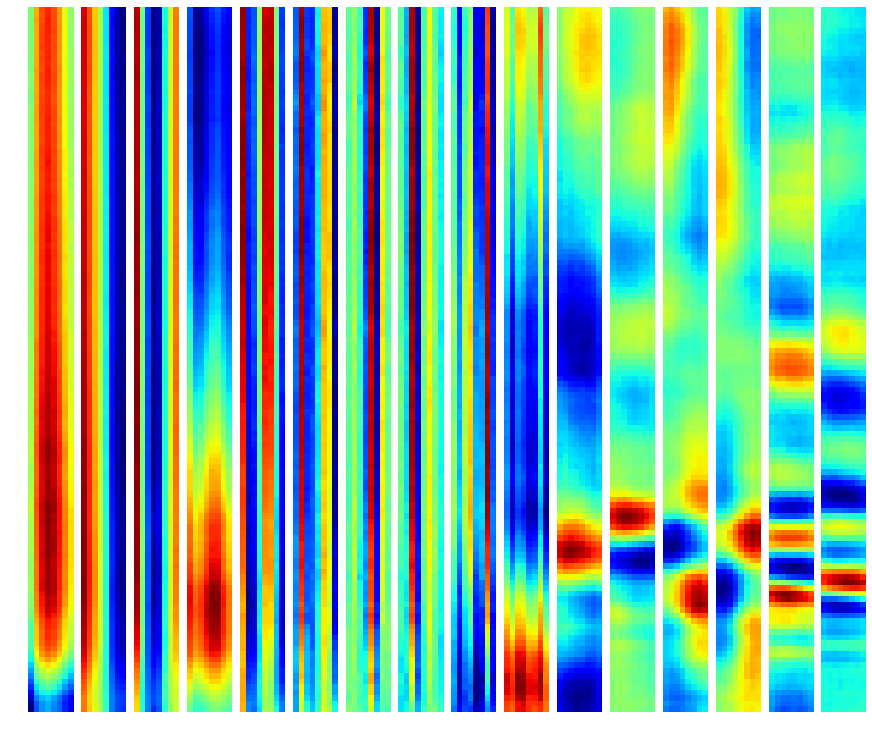

In [87]:
plt.figure(figsize=(15, 15))

for count, comp in enumerate(pca.components_[:16]):
    plt.subplot(1, 16, count+1)
    plt.imshow(comp.reshape(128, 8), interpolation='nearest')
    plt.gca().invert_yaxis()
    plt.axis('off')

-5.03762 4.21703 -3.54447977748 3.39133633738
-3.5888 2.26247 -2.2886838873 1.28214707669
-2.7601 2.48899 -1.82256097649 2.04446824977
-4.06466 2.48899 -1.91104402222 1.45586355765
-4.06466 2.70383 -2.47995842383 2.12791749998
-2.57669 2.70383 -1.3245956828 2.13075349049
-2.95132 2.72258 -1.29277310441 2.31877467588
-2.95132 2.72258 -2.62054729097 1.72853414055


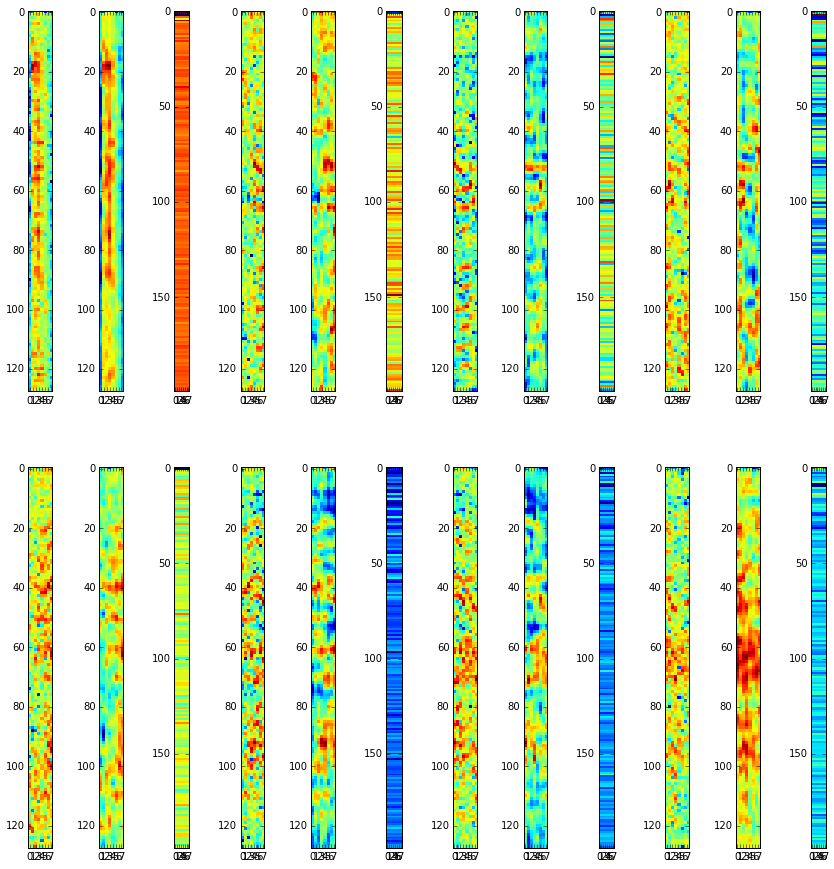

In [88]:
plt.figure(figsize=(15, 15))

for idx in range(8):
    
    orig = strips[idx]
    pca_ed = pca.transform(orig.ravel())
    new = pca.inverse_transform(pca_ed)

    plt.subplot(2, 12, 3*idx + 1)
    plt.imshow(orig.reshape(128, 8), interpolation='nearest')
    
    plt.subplot(2, 12, 3*idx + 2)
    plt.imshow(new.reshape(128, 8), interpolation='nearest')
    
    plt.subplot(2, 12, 3*idx + 3)
    to_show = np.tile(pca_ed.T, (1, 8))
    plt.imshow(to_show, interpolation='nearest')
    
    print orig.min(), orig.max(), new.min(), new.max()

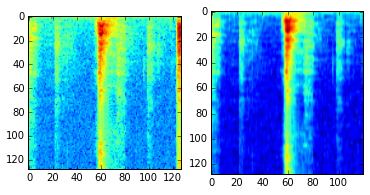

In [89]:
# lets try dividing up a spectrogram into strips and whitening each strip in separate...
spec_in = data['train_X'][102]
this_spec = split_spec(spec_in, width=8, spacing=8)
this_spec_comp = [pca.inverse_transform(pca.transform(ss.ravel())).reshape(128, 8)
                  for ss in this_spec]

plt.subplot(121)
plt.imshow(spec_in)

plt.subplot(122)
plt.imshow(np.hstack(this_spec_comp))